In [1]:
!pip install transformers
!pip install einops
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Male_Border_Collie_Standing.jpg/640px-Male_Border_Collie_Standing.jpg -O Border_Collie.jpg

--2025-02-06 19:43:30--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Male_Border_Collie_Standing.jpg/640px-Male_Border_Collie_Standing.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76681 (75K) [image/jpeg]
Saving to: ‘Border_Collie.jpg’

Border_Collie.jpg   100%[===================>]  74.88K  --.-KB/s    in 0.02s   

2025-02-06 19:43:31 (4.31 MB/s) - ‘Border_Collie.jpg’ saved [76681/76681]



In [2]:
import torch
from transformers import AutoModel
from transformers import CLIPImageProcessor, CLIPTokenizer
from torchvision.transforms import Normalize
from PIL import Image
from modeling_qlip import QLIPModel

processor = CLIPImageProcessor.from_pretrained("nvidia/QLIP-B-8-256")
tokenizer = CLIPTokenizer.from_pretrained("nvidia/QLIP-B-8-256")
model = QLIPModel.from_pretrained("nvidia/QLIP-B-8-256")

/home/yzhao/miniconda3/envs/qlip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yzhao/miniconda3/envs/qlip/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
image_path = "Border_Collie.jpg"
image = Image.open(image_path)
captions = ["a diagram", "a dog", "a cat"]

input_ids = tokenizer(captions, return_tensors="pt", padding=True).input_ids
input_pixels = processor(images=image, return_tensors="pt", padding=True).pixel_values
outputs = model(input_ids, input_pixels)


inverse_normalize = Normalize(
    mean=[-m / s for m, s in zip(processor.image_mean, processor.image_std)],
    std=[1 / s for s in processor.image_std]
)
input2 = inverse_normalize(input_pixels[0]).clamp_(0, 1)
recon = inverse_normalize(outputs["reconstructions"][0]).clamp_(0, 1)


with torch.no_grad():
    image_features = outputs["image_embeds"] # equivalent to: `image_features = model.get_image_features(input_pixels)`
    text_features = outputs["text_embeds"]   # equivalent to: `text_features = model.get_text_features(input_ids)`
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

label_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
print(f"model label_probs: {label_probs}")

model label_probs: tensor([[1.2432e-06, 9.9873e-01, 1.2678e-03]], grad_fn=<SoftmaxBackward0>)


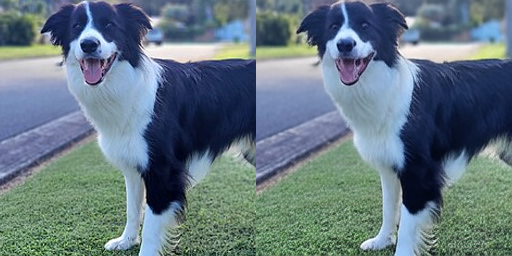

In [4]:
collage = torch.cat([input2, recon], dim=2)
collage = (collage * 255).to(torch.uint8).numpy().transpose(1, 2, 0)
Image.fromarray(collage)